In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
!pip install --upgrade matplotlib seaborn numpy

  Using cached numpy-2.1.2-cp311-cp311-macosx_14_0_arm64.whl.metadata (60 kB)


In [3]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale


import numpy as np
import pandas as pd

In [4]:
train_df = pd.read_csv("/Users/anchanghun/Downloads/UNSW-NB15/CSV Files/UNSW-NB15/UNSW_NB15_training-set.csv")

In [5]:
test_df = pd.read_csv("/Users/anchanghun/Downloads/UNSW-NB15/CSV Files/UNSW-NB15/UNSW_NB15_testing-set.csv")


In [6]:
train_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [7]:
test_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [8]:
train_df.shape

(175341, 45)

In [9]:
test_df.shape

(82332, 45)

In [10]:
df=pd.concat([train_df, test_df], axis=0)

In [11]:
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [12]:
df['label'].value_counts()

label
1    164673
0     93000
Name: count, dtype: int64

In [13]:
# 추출할 컬럼 리스트
columns_to_extract = ['id', 'state', 'rate', 'sttl', 'dload', 'swin', 'stcpb', 'dtcpb',
                      'dwin', 'dmean', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
                      'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_src_ltm',
                      'ct_srv_dst', 'attack_cat', 'label']

df = df[columns_to_extract]

In [14]:
df.isnull().values.any()

False

In [15]:
len(df.columns)

20

In [16]:
df.shape

(257673, 20)

In [17]:
df.columns

Index(['id', 'state', 'rate', 'sttl', 'dload', 'swin', 'stcpb', 'dtcpb',
       'dwin', 'dmean', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_src_ltm',
       'ct_srv_dst', 'attack_cat', 'label'],
      dtype='object')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257673 entries, 0 to 82331
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                257673 non-null  int64  
 1   state             257673 non-null  object 
 2   rate              257673 non-null  float64
 3   sttl              257673 non-null  int64  
 4   dload             257673 non-null  float64
 5   swin              257673 non-null  int64  
 6   stcpb             257673 non-null  int64  
 7   dtcpb             257673 non-null  int64  
 8   dwin              257673 non-null  int64  
 9   dmean             257673 non-null  int64  
 10  ct_srv_src        257673 non-null  int64  
 11  ct_state_ttl      257673 non-null  int64  
 12  ct_dst_ltm        257673 non-null  int64  
 13  ct_src_dport_ltm  257673 non-null  int64  
 14  ct_dst_sport_ltm  257673 non-null  int64  
 15  ct_dst_src_ltm    257673 non-null  int64  
 16  ct_src_ltm        257673 n

In [23]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding 적용
label_encoder = LabelEncoder()
#df['proto'] = label_encoder.fit_transform(df['proto'])
df['state'] = label_encoder.fit_transform(df['state'])
#df['service'] = label_encoder.fit_transform(df['service'])
df['attack_cat'] = label_encoder.fit_transform(df['attack_cat'])

# 인코딩된 데이터프레임 확인
print(df.head())

   id  state       rate  sttl          dload  swin       stcpb       dtcpb  \
0   1      4  74.087490   252    8495.365234   255   621772692  2202533631   
1   2      4  78.473372    62  503571.312500   255  1417884146  3077387971   
2   3      4  14.170161    62   60929.230470   255  2116150707  2963114973   
3   4      4  13.677108    62    3358.622070   255  1107119177  1047442890   
4   5      4  33.373826   254    3987.059814   255  2436137549  1977154190   

   dwin  dmean  ct_srv_src  ct_state_ttl  ct_dst_ltm  ct_src_dport_ltm  \
0   255     43           1             0           1                 1   
1   255   1106          43             1           1                 1   
2   255    824           7             1           2                 1   
3   255     64           1             1           2                 1   
4   255     45          43             1           2                 2   

   ct_dst_sport_ltm  ct_dst_src_ltm  ct_src_ltm  ct_srv_dst  attack_cat  label  
0    

In [24]:
df.head()

,id,state,rate,sttl,dload,swin,stcpb,dtcpb,dwin,dmean,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,attack_cat,label
0,1,4,74.087490,252,8495.365234,255,621772692,2202533631,255,43,1,0,1,1,1,1,1,1,6,0
1,2,4,78.473372,62,503571.312500,255,1417884146,3077387971,255,1106,43,1,1,1,1,2,1,6,6,0
2,3,4,14.170161,62,60929.230470,255,2116150707,2963114973,255,824,7,1,2,1,1,3,2,6,6,0
3,4,4,13.677108,62,3358.622070,255,1107119177,1047442890,255,64,1,1,2,1,1,3,2,1,6,0
4,5,4,33.373826,254,3987.059814,255,2436137549,1977154190,255,45,43,1,2,2,1,40,2,39,6,0


In [25]:
df['label'].value_counts()

label
1    164673
0     93000
Name: count, dtype: int64

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.1, random_state=42)
X_train.shape, X_test.shape

((231905, 20), (25768, 20))

In [27]:
X_train_normal = X_train[X_train['label'] == 1]
X_train_normal.shape

X_test_normal = X_test[X_test['label'] == 1]
X_test_normal.shape

(16489, 20)

In [28]:
y_train_normal = X_train_normal['label']
X_train_normal = X_train_normal.drop(labels='label',axis=1)

y_test_normal = X_test_normal['label']
X_test_normal = X_test_normal.drop(labels='label',axis=1)

In [29]:
y_test = X_test['label']
X_test = X_test.drop(labels='label', axis=1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_normal = scaler.fit_transform(X_train_normal)
X_test = scaler.fit_transform(X_test)

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_normal = scaler.fit_transform(X_train_normal)
X_test = scaler.fit_transform(X_test)

In [31]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Conv1D, Conv1DTranspose
from keras.models import Model
from keras import regularizers
from keras_self_attention import SeqWeightedAttention, SeqSelfAttention
from keras.callbacks import EarlyStopping

ModuleNotFoundError: No module named 'keras_self_attention'

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Model, Input
import numpy as np
from tensorflow.keras import backend as K

latent_dim = 10
inter_dim = 20

# Sampling function for reparameterization trick
def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + z_log_sigma * epsilon

def vae_loss(x, x_decoded_mean, z_mean, z_log_sigma):
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean), axis=1)
    kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    kl_loss_weighted = kl_loss * 0.0001  # KL 다이버전스 손실에 가중치 부여
    total_loss = K.mean(reconstruction_loss + kl_loss_weighted)
    return total_loss

def cvae(X, labels):
    features = X.shape[1]  # 2D 데이터이므로 timesteps는 필요 없고, features만 사용
    input_x = Input(shape=(features,), name='InputFeatures')  # 2D 입력 (샘플, 특징)

    input_label = Input(shape=(1,), name='InputLabel')  # Assumes binary or multi-class label

    # Embed the label into the same shape as the input
    embedded_label = layers.Embedding(input_dim=2, output_dim=features)(input_label)  # Adjust output_dim to match features
    embedded_label = layers.Flatten()(embedded_label)

    # Concatenate input_x and embedded_label
    concatenated_input = layers.Concatenate()([input_x, embedded_label])

    # Reshape for Conv1D layer (to 3D)
    reshaped_input = layers.Reshape((features + embedded_label.shape[-1], 1))(concatenated_input)

    # Encoder with CNN layers
    h = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same')(reshaped_input)
    h = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same')(h)
    h = layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same')(h)

    # Flatten for dense layers (MLP)
    h = layers.Flatten()(h)
    h = layers.Dense(inter_dim, activation='relu')(h)
    h = layers.Dense(inter_dim, activation='relu')(h)

    # z layer
    z_mean = layers.Dense(latent_dim)(h)
    z_log_sigma = layers.Dense(latent_dim)(h)
    z = layers.Lambda(sampling)([z_mean, z_log_sigma])

    # Decoder
    # Add the label to the latent space z
    z_with_label = layers.Concatenate()([z, embedded_label])

    # Expand for Conv1DTranspose layer
    decoder1 = layers.Dense((features + embedded_label.shape[-1]) * inter_dim)(z_with_label)
    decoder1 = layers.Reshape((features + embedded_label.shape[-1], inter_dim))(decoder1)

    # Decoder with CNN layers
    decoder1 = layers.Conv1DTranspose(filters=16, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=32, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=64, kernel_size=3, activation="relu", padding='same')(decoder1)

    # Flatten and final dense layer to reconstruct original features
    decoder1 = layers.Flatten()(decoder1)
    decoder1 = layers.Dense(features)(decoder1)
    
    model = Model([input_x, input_label], decoder1)
    model.add_loss(vae_loss(input_x, decoder1, z_mean, z_log_sigma))
    
    return model

# Create CVAE model
model = cvae(X_train_normal, y_train_normal)
model.summary()

from tensorflow.keras.callbacks import EarlyStopping
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile and train the model with early stopping
history = model.fit([X_train_normal, y_train_normal], X_train_normal,
                    shuffle=True,
                    epochs=100, 
                    validation_split=0.1,  
                    batch_size=32,
                    callbacks=[early_stopping]).history
'''
# Compile and train the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = model.fit([X_train_normal, y_train_normal], X_train_normal,
                    shuffle=True,
                    epochs=50, 
                    validation_split=0.1,  
                    batch_size=32).history  
'''


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputLabel (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 19)                38        ['InputLabel[0][0]']          
                                                                                                  
 InputFeatures (InputLayer)  [(None, 19)]                 0         []                            
                                                                                                  
 flatten (Flatten)           (None, 19)                   0         ['embedding[0][0]']           
                                                                                              

                                                                                                  
 tf.math.multiply_1 (TFOpLa  (None,)                      0         ['tf.math.multiply[0][0]']    
 mbda)                                                                                            
                                                                                                  
 tf.__operators__.add_1 (TF  (None,)                      0         ['tf.math.reduce_sum[0][0]',  
 OpLambda)                                                           'tf.math.multiply_1[0][0]']  
                                                                                                  
 tf.math.reduce_mean (TFOpL  ()                           0         ['tf.__operators__.add_1[0][0]
 ambda)                                                             ']                            
                                                                                                  
 add_loss 

Epoch 1/100
4168/4168 [==============================] - 15s 3ms/step - loss: 0.0512 - accuracy: 0.7598 - val_loss: 0.0058 - val_accuracy: 0.8544
Epoch 2/100
4168/4168 [==============================] - 13s 3ms/step - loss: 0.0052 - accuracy: 0.7824 - val_loss: 0.0049 - val_accuracy: 0.8575
Epoch 3/100
4168/4168 [==============================] - 13s 3ms/step - loss: 0.0038 - accuracy: 0.7858 - val_loss: 0.0033 - val_accuracy: 0.7889
Epoch 4/100
4168/4168 [==============================] - 13s 3ms/step - loss: 0.0026 - accuracy: 0.7891 - val_loss: 0.0029 - val_accuracy: 0.8503
Epoch 5/100
4168/4168 [==============================] - 13s 3ms/step - loss: 0.0021 - accuracy: 0.7896 - val_loss: 0.0014 - val_accuracy: 0.7780
Epoch 6/100
4168/4168 [==============================] - 13s 3ms/step - loss: 0.0017 - accuracy: 0.7913 - val_loss: 0.0015 - val_accuracy: 0.7833
Epoch 7/100
4168/4168 [==============================] - 14s 3ms/step - loss: 0.0014 - accuracy: 0.7929 - val_loss: 0.0012 -

"\n# Compile and train the model\nmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])\nhistory = model.fit([X_train_normal, y_train_normal], X_train_normal,\n                    shuffle=True,\n                    epochs=50, \n                    validation_split=0.1,  \n                    batch_size=32).history  \n"

In [33]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_shapes.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


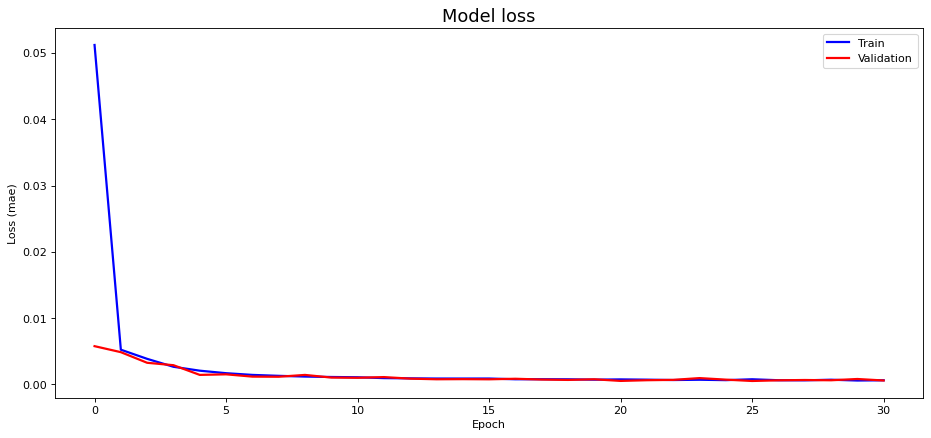

In [34]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [35]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [36]:
X_test.shape

(25768, 19)

In [37]:
valid_x_predictions = model.predict([X_test, y_test])
#mse = np.mean(np.power(flatten(test_X_selected) - flatten(valid_x_predictions), 2), axis=1)

mse = np.mean(np.power(X_test - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test.tolist()})

806/806 [==============================] - 1s 1ms/step


In [38]:
error_df

,reconstruction_error,true_class
0,0.001118,1
1,0.000995,1
2,0.020030,0
3,0.002680,1
4,0.046611,0
...,...,...
25763,0.002415,1
25764,0.001028,1
25765,0.001048,1
25766,0.001053,1


In [39]:
error_df['true_class'].value_counts()

true_class
1    16489
0     9279
Name: count, dtype: int64

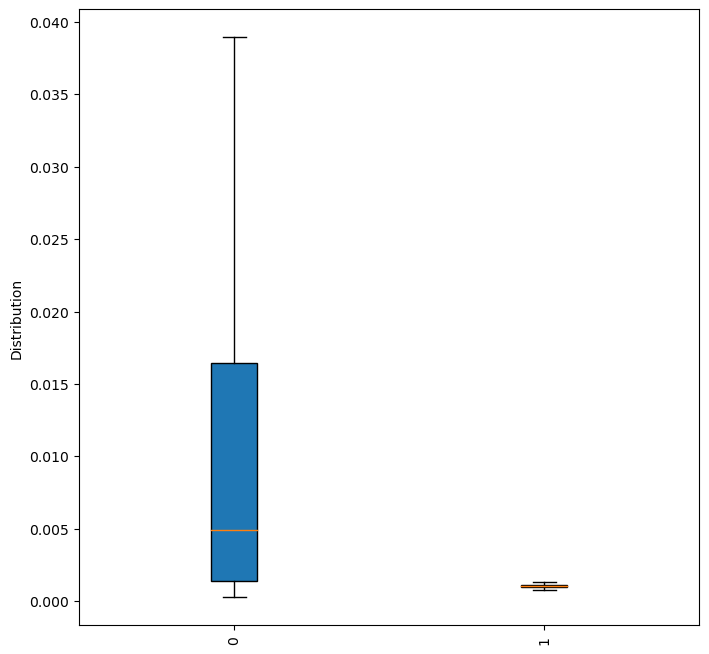

In [40]:
import matplotlib.pyplot as plt

# 데이터프레임 준비
true_class = error_df['true_class'].astype(str)
reconstruction_error = error_df['reconstruction_error']

# 박스 플롯 그리기
plt.figure(figsize=(8, 8))
plt.boxplot(
    [reconstruction_error[true_class == cls] for cls in sorted(true_class.unique())],
    labels=sorted(true_class.unique()),
    showfliers=False,
    vert=True,
    patch_artist=True
)

plt.ylabel('Distribution')
plt.xticks(rotation=90)
plt.show()


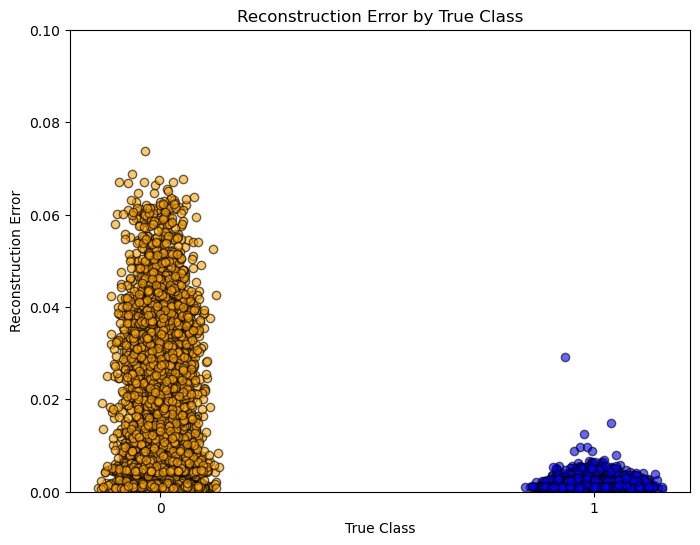

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data for plotting
true_class_0 = error_df[error_df['true_class'] == 0]['reconstruction_error']
true_class_1 = error_df[error_df['true_class'] == 1]['reconstruction_error']

# Create the figure and axes with a specified y-axis limit
plt.figure(figsize=(8, 6))

# Add jitter to avoid overlapping points in the scatter plot
x_0 = np.random.normal(1, 0.04, size=len(true_class_0))  # Jitter for class 0
x_1 = np.random.normal(2, 0.04, size=len(true_class_1))  # Jitter for class 1

# Create the scatter plot
plt.scatter(x_0, true_class_0, color='orange', alpha=0.6, edgecolor='black', label='Class 0')
plt.scatter(x_1, true_class_1, color='blue', alpha=0.6, edgecolor='black', label='Class 1')

# Set y-axis limit
plt.ylim(0, 0.1)

# Set x-axis labels and adjust ticks
plt.xticks([1, 2], ['0', '1'])
plt.xlabel('True Class')

# Set y-axis label and title
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error by True Class')

# Display the plot
plt.show()


Best threshold: 0.001
Best F1 score: 0.6387879465533628


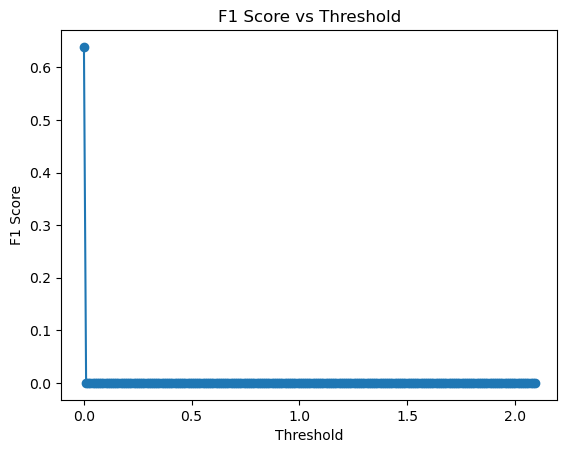

In [45]:


import numpy as np
from sklearn.metrics import f1_score

# Define the range of threshold values
threshold_range = np.arange(0.001, 2.1, 0.01)

# List to store F1 scores for each threshold
f1_scores = []

# Loop through each threshold and calculate F1 score
for threshold in threshold_range:
    y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]
    f1 = f1_score(error_df.true_class, y_pred)
    f1_scores.append(f1)

# Find the threshold with the highest F1 score
best_threshold = threshold_range[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f"Best threshold: {best_threshold}")
print(f"Best F1 score: {best_f1_score}")

# Optionally, you can plot the F1 scores across the threshold range
plt.plot(threshold_range, f1_scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.show()


In [46]:
print(error_df)

       reconstruction_error  true_class
0                  0.001118           1
1                  0.000995           1
2                  0.020030           0
3                  0.002680           1
4                  0.046611           0
...                     ...         ...
25763              0.002415           1
25764              0.001028           1
25765              0.001048           1
25766              0.001053           1
25767              0.000972           0

[25768 rows x 2 columns]


In [47]:
print(error_df[(error_df['reconstruction_error'] >= 0.001) & (error_df['true_class'] == 0)].count())

reconstruction_error    7859
true_class              7859
dtype: int64


In [48]:
print(error_df[(error_df['reconstruction_error'] < 3) & (error_df['true_class'] == 1)].count())

reconstruction_error    16489
true_class              16489
dtype: int64


In [50]:
# 그래프 보고 threshold 결정 0.35
threshold = 0.0001

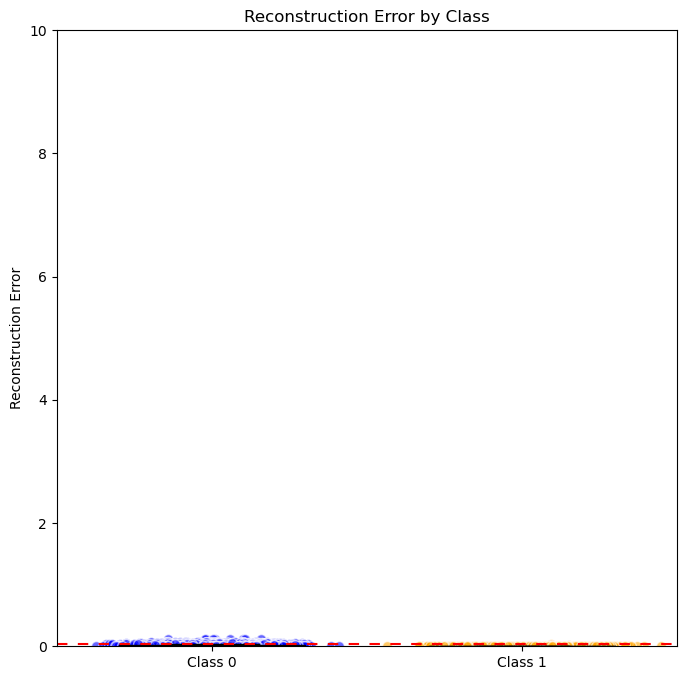

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for plotting
true_class_0 = error_df[error_df['true_class'] == 0]['reconstruction_error']
true_class_1 = error_df[error_df['true_class'] == 1]['reconstruction_error']

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 8))

# Create a swarm plot equivalent using scatter plot with more jitter
x_0 = np.random.normal(1, 0.1, size=len(true_class_0))  # Increased jitter for class 0
x_1 = np.random.normal(2, 0.1, size=len(true_class_1))  # Increased jitter for class 1

ax.scatter(x_0, true_class_0, color='blue', alpha=0.6, label='Class 0', edgecolor='w', s=50)
ax.scatter(x_1, true_class_1, color='orange', alpha=0.6, label='Class 1', edgecolor='w', s=50)

# Create boxplots
ax.boxplot([true_class_0, true_class_1], positions=[1, 2], widths=0.6, patch_artist=True, 
           showfliers=False, boxprops=dict(facecolor='None', color='black'),
           medianprops=dict(color='black'), whiskerprops=dict(color='black'))

# Set x-axis labels
ax.set_xticks([1, 2])
ax.set_xticklabels(['Class 0', 'Class 1'])

# Add a horizontal line at the threshold
ax.axhline(y=0.03, xmin=0.0, xmax=1, dashes=(5, 5), color='red')

# Adjust y-axis limit to make sure the threshold line is visible
#ax.set_ylim(bottom=min(min(true_class_0), min(true_class_1)) - 0.01, 
#           top=max(max(true_class_0), max(true_class_1)) + 0.01)
ax.set_ylim(bottom=0, top=10)
    
# Set labels and title
ax.set_ylabel('Reconstruction Error')
ax.set_title('Reconstruction Error by Class')

plt.show()


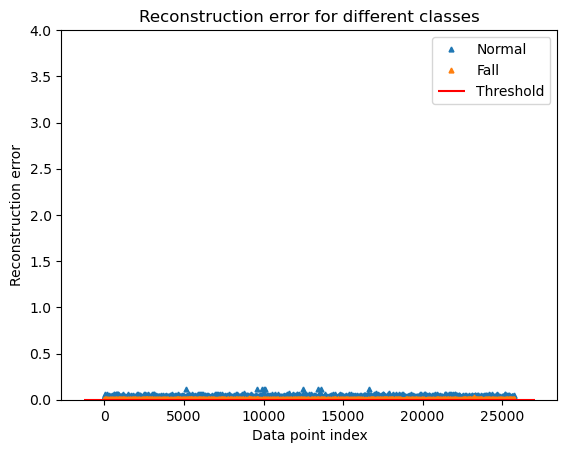

In [52]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
            label= "Normal" if name == 0 else "Fall")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.set_ylim(0, 4)
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

<Figure size 1200x1200 with 0 Axes>

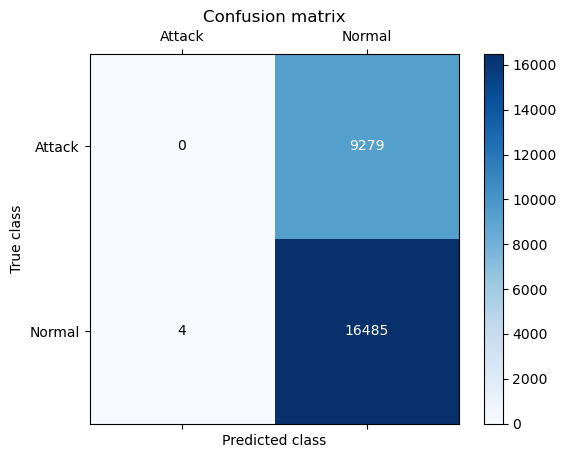

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have already defined LABELS, threshold, and y_pred

LABELS = ["Attack", "Normal"]

y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

# Create the figure and axis
plt.figure(figsize=(12, 12))
fig, ax = plt.subplots()

# Plot the confusion matrix using imshow
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

# Add color bar
plt.colorbar(cax)

# Set the labels for the axes
ax.set_xticks(np.arange(len(LABELS)))
ax.set_yticks(np.arange(len(LABELS)))

ax.set_xticklabels(LABELS)
ax.set_yticklabels(LABELS)

# Set labels and title
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix')

# Annotate the confusion matrix with the counts
for i in range(len(LABELS)):
    for j in range(len(LABELS)):
        ax.text(j, i, format(conf_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()


In [54]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.6397469729897547
Precision : 0.6398462971588262
Recall : 0.9997574140335982
F1 : 0.7802996236953589


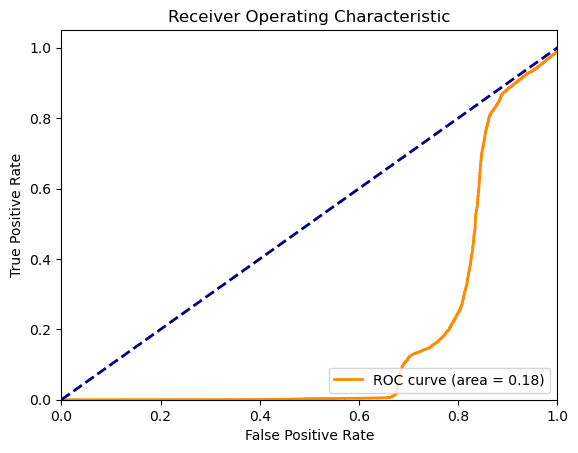

In [55]:
from sklearn.metrics import roc_curve, auc

# Assuming y_test and reconstruction_error have been defined
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


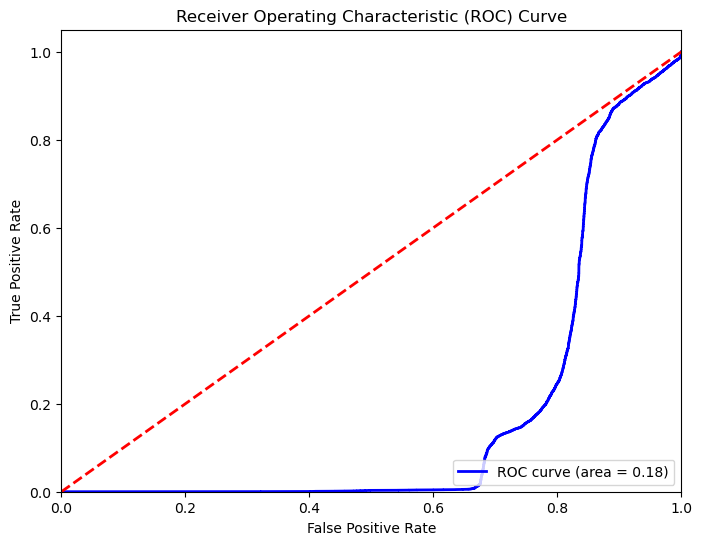

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extract the true labels and reconstruction errors from error_df
y_true = error_df['true_class']
y_scores = error_df['reconstruction_error']

# Compute the False Positive Rate (FPR) and True Positive Rate (TPR) for different thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')

# Set plot labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Display the plot
plt.show()


In [57]:
# If error_df.true_class is a nested structure, flatten it
y_test = error_df.true_class.apply(lambda x: int(x[0][0]) if isinstance(x, list) else int(x))

# Ensure y_pred is a list of integers
y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]

# Now calculate the metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


Accuracy Score: 0.6397469729897547
Precision: 0.6398462971588262
Recall: 0.9997574140335982
F1 Score: 0.7802996236953589


In [58]:
print(roc_auc)

0.17591562918127218
